In [25]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# variables 
tickers = ['NVDA','AMD','SOXX','TSM']

In [27]:
ticker_dfs = {}
latest_start = []
for ticker in tickers:
    temp = yf.Ticker(ticker)
    temp_df = temp.history(period='max')
    ticker_dfs[ticker] = temp_df
    temp_df.index = temp_df.index.tz_localize(None).normalize()
    latest_start.append(temp_df.index.min())

for ticker in tickers:
    ticker_dfs[ticker] = ticker_dfs[ticker][ticker_dfs[ticker].index >= max(latest_start)]
    print(ticker_dfs[ticker].index[0])


    

2001-07-13 00:00:00
2001-07-13 00:00:00
2001-07-13 00:00:00
2001-07-13 00:00:00


lead/lag

In [28]:
correlations = {}
for ticker in tickers:
    max_lag = 29  # days
    lags = np.arange(-max_lag, max_lag + 1)
    nvda_close = ticker_dfs['NVDA']['Close']
    ticker_close = ticker_dfs[ticker]['Close']

    for lag in lags:
        #print(lag)
        ticker_shifted = ticker_close.shift(lag)
        ticker_fin = ticker_shifted.dropna()  # shift forward/backward
        nvda_close_ticker = nvda_close[nvda_close.index.isin(ticker_fin.index)]
        # print(nvda_close_amd.index[0:5],len(nvda_close_amd.index))
        # print(amd_fin.index[0:5],len(amd_fin.index))
        corr = np.corrcoef(nvda_close_ticker, ticker_fin)[0,1]
        correlations[ticker, lag] = corr


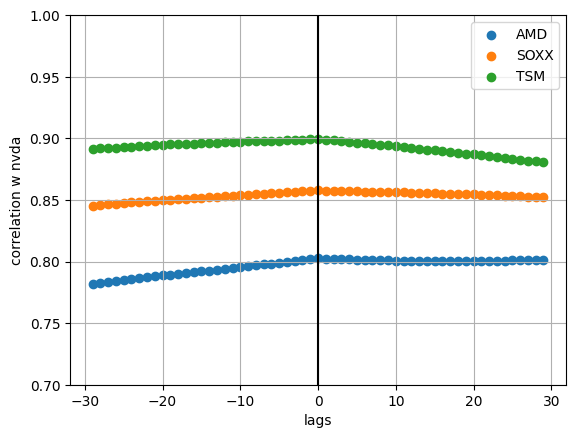

In [29]:
for ticker in tickers:
    if ticker != 'NVDA':
        plt.scatter(lags,[correlations[ticker, lag] for lag in lags], label = ticker)
plt.plot([0,0],[0,1], color='black')
plt.ylim([0.7,1])
plt.legend()
plt.xlabel('lags')
plt.ylabel('correlation w nvda')
plt.grid()

nvdas strongest lead/lag is from TSM, which has the highest correlation when using a negative lag wrt nvda. This means that TSM leads nvda

In [30]:
# define TSM rally 

NVDA = ticker_dfs['NVDA']
TSM = ticker_dfs['TSM']
TSM['Gain'] = TSM['Close'].pct_change(periods=1)
tsm_gain_std = np.std(TSM['Gain'])
tsm_gain_mean = np.mean(TSM['Gain'])

/tmp/ipykernel_116245/2373619987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TSM['Gain'] = TSM['Close'].pct_change(periods=1)


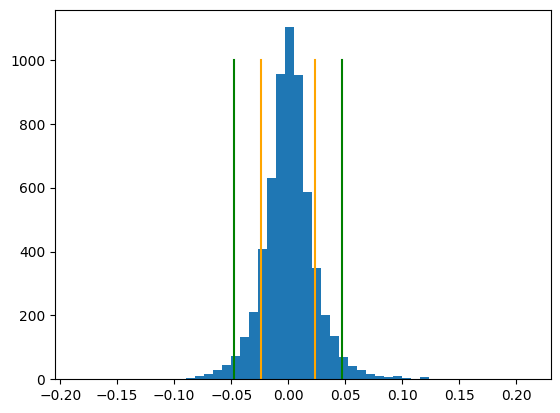

In [31]:
plt.hist(TSM['Gain'],bins=50)
plt.plot([tsm_gain_std, tsm_gain_std],[0,1000],color='orange')
plt.plot([-tsm_gain_std, -tsm_gain_std],[0,1000],color='orange')
plt.plot([2*tsm_gain_std, 2*tsm_gain_std],[0,1000],color='green')
plt.plot([-2*tsm_gain_std, -2*tsm_gain_std],[0,1000],color='green')

# we'll use a gain of 2stds from the norm as our "rally" signal